## imports

In [347]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
import os
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform, cosine, euclidean, mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from PIL import Image
from IPython.core.debugger import set_trace
import nethook as nethook
import scipy.io as sio
from tqdm import tqdm
import time
import importlib
import rsatools as rsa
import nnutils as utils
import torchvision.datasets as datasets
from floc_selectivity import floc_selectivity

importlib.reload(rsa)
importlib.reload(utils)

<module 'nnutils' from '/home/jacobpri/git/RotspaceIT/notebooks/nnutils.py'>

In [348]:
## hyperparameters
arch = 'alexnet'
trained_on = 'object'
imageset = 'imagefiles-fullset'
img_dim = 224
batch_size = 80
FDR_p = 0.05
save_as = '.npy'
overwrite = False
verbose = True
draw_plots = True

In [349]:
## directory management

home_dir = '/home/jacobpri/git/RotspaceIT/'

# target directory for loading activations
activation_loaddir = join(home_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise pref dicts
prefdict_savedir = join(home_dir,'data','d02_modeling','selectivity')

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + trained_on

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_loaddir = join(activation_loaddir, load_arch, d, imageset, 'dim' + str(img_dim))
        prefdict_savedir = join(prefdict_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break

if found is False:
    raise ValueError('image set not found')   

# create savedir if it doesn't yet exist 
os.makedirs(prefdict_savedir, exist_ok=True)

print("imageset dir %s\n" % imageset_dir)
print("activation load destination: %s\n" % activation_loaddir)
print("prefdict save destination: %s\n" % prefdict_savedir)

assert(exists(activation_loaddir))
assert(exists(imageset_dir))
assert(exists(prefdict_savedir))
assert(save_as == '.npy' or save_as == '.mat')

imageset dir /home/jacobpri/git/RotspaceIT/imagesets/localizer/imagefiles-fullset

activation load destination: /home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224

prefdict save destination: /home/jacobpri/git/RotspaceIT/data/d02_modeling/selectivity/alexnet-object/localizer/imagefiles-fullset/dim224



In [350]:
layer_names_fn = join(activation_loaddir, 'lay_names_user_fmt_batchsize-' + str(batch_size) + '.npy')
assert(exists(layer_names_fn))

layer_names = np.load(layer_names_fn)

all_types = ['conv','relu','pool','norm','drop','fc','downsample','identity','flatten']
includes = all_types #['conv','fc','relu']#all_types#['relu','conv','fc']#all_types#['conv','fc','relu']#all_types#['conv','relu','fc','relu','norm','drop','pool','flatten']#all_types#['conv','fc']

layers_to_load = []

for i in range(len(layer_names)):
    if any(s in layer_names[i] for s in includes):
        layers_to_load.append(layer_names[i])

print(layers_to_load,'\n')
print('%d layers chosen' % len(layers_to_load))

['1_conv1', '2_relu1', '3_maxpool1', '4_conv2', '5_relu2', '6_maxpool2', '7_conv3', '8_relu3', '9_conv4', '10_relu4', '11_conv5', '12_relu5', '13_maxpool5', '14_avgpool5', '15_drop5', '16_fc6', '17_relu6', '18_drop6', '19_fc7', '20_relu7', '21_fc8'] 

21 layers chosen


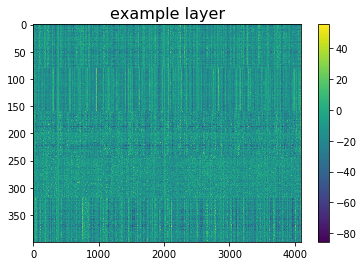

In [351]:
## load batched activations, reshape to 2d, concatenate

# test on a single layer
Y = utils.load_batched_activations(activation_loaddir, ['19_fc7'], batch_size)

if draw_plots is True:
    rsa.plot_matrix(Y,tl = 'example layer',fontsize=16)

In [352]:
## organize category indices

dataset = datasets.ImageFolder(root = imageset_dir)

# print some info -> verify correct # imgs, etc
categ_idx = np.array(dataset.targets)

if imageset == 'vpnl-floc':
    floc_categs = np.array(['adult','body','car','child','corridor','house','instrument','limb','number','scrambled','word'])
    floc_domains = np.array(['faces','bodies','objects','scenes','characters','scrambled'])
    floc_categ_domain_ref = np.array([0,1,2,0,3,3,2,1,4,5,4])
    categ_nimg = 144

    categ_idx = np.repeat(floc_categ_domain_ref,categ_nimg)
else:
    floc_domains = dataset.classes

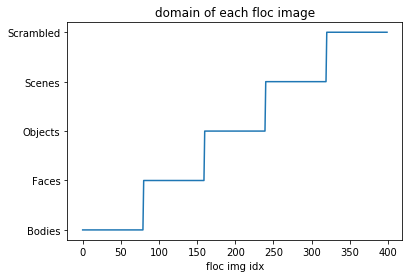

In [353]:
if draw_plots is True:
    ## visualize, for sanity
    plt.figure()
    plt.plot(categ_idx)
    plt.yticks(np.arange(len(floc_domains)),floc_domains);
    plt.xlabel('floc img idx')
    plt.title('domain of each floc image');

Conducting deepnet floc experiments:   0%|          | 0/100 [00:00<?, ?it/s]

1_conv1


Conducting deepnet floc experiments:   5%|▍         | 4.761904761904762/100 [00:08<02:43,  1.72s/it]

2_relu1


Conducting deepnet floc experiments:  10%|▉         | 9.523809523809524/100 [00:16<02:35,  1.72s/it]

3_maxpool1


Conducting deepnet floc experiments:  14%|█▍        | 14.285714285714285/100 [00:18<01:54,  1.34s/it]

4_conv2


Conducting deepnet floc experiments:  19%|█▉        | 19.047619047619047/100 [00:24<01:47,  1.32s/it]

5_relu2


Conducting deepnet floc experiments:  24%|██▍       | 23.80952380952381/100 [00:30<01:39,  1.31s/it] 

6_maxpool2


Conducting deepnet floc experiments:  29%|██▊       | 28.571428571428573/100 [00:32<01:11,  1.01s/it]

7_conv3


Conducting deepnet floc experiments:  33%|███▎      | 33.333333333333336/100 [00:35<00:59,  1.12it/s]

8_relu3


Conducting deepnet floc experiments:  38%|███▊      | 38.095238095238095/100 [00:38<00:50,  1.23it/s]

9_conv4


Conducting deepnet floc experiments:  43%|████▎     | 42.857142857142854/100 [00:40<00:39,  1.44it/s]

10_relu4


Conducting deepnet floc experiments:  48%|████▊     | 47.61904761904761/100 [00:42<00:31,  1.64it/s] 

11_conv5


Conducting deepnet floc experiments:  52%|█████▏    | 52.38095238095237/100 [00:44<00:26,  1.81it/s]

12_relu5


Conducting deepnet floc experiments:  57%|█████▋    | 57.14285714285713/100 [00:45<00:21,  1.97it/s]

13_maxpool5


Conducting deepnet floc experiments:  62%|██████▏   | 61.90476190476189/100 [00:46<00:14,  2.60it/s]

14_avgpool5


Conducting deepnet floc experiments:  67%|██████▋   | 66.66666666666666/100 [00:46<00:09,  3.35it/s]

15_drop5


Conducting deepnet floc experiments:  71%|███████▏  | 71.42857142857142/100 [00:47<00:06,  4.19it/s]

16_fc6


Conducting deepnet floc experiments:  76%|███████▌  | 76.19047619047618/100 [00:47<00:04,  5.37it/s]

17_relu6


Conducting deepnet floc experiments:  81%|████████  | 80.95238095238093/100 [00:47<00:02,  6.74it/s]

18_drop6


Conducting deepnet floc experiments:  86%|████████▌ | 85.7142857142857/100 [00:48<00:01,  8.23it/s] 

19_fc7


Conducting deepnet floc experiments:  90%|█████████ | 90.47619047619045/100 [00:48<00:00,  9.72it/s]

20_relu7


Conducting deepnet floc experiments: 100%|█████████▉| 99.99999999999997/100 [00:48<00:00,  2.04it/s]


21_fc8
(21, 5)


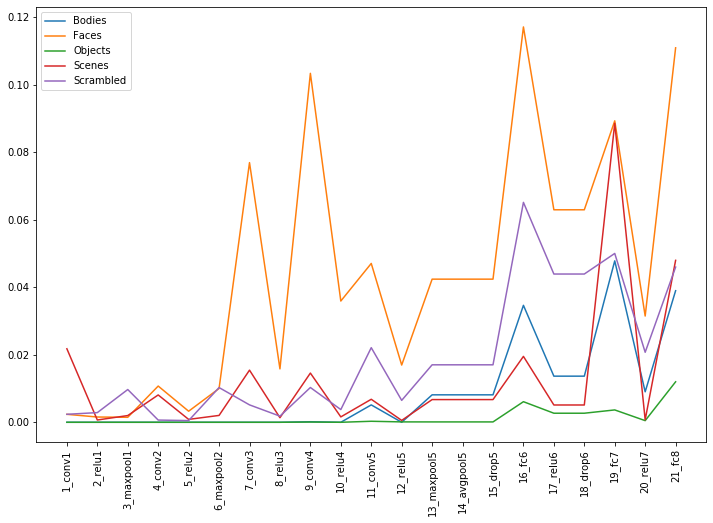

In [354]:
## run deepnet floc experiment, returning a dict with each layer's pref dict
pref_dicts = dict()

with tqdm(total=100,desc='Conducting deepnet floc experiments') as pbar:
    for layer in layers_to_load:
        
        print(layer)
        time.sleep(0.1) 
        
        Y = utils.load_batched_activations(activation_loaddir, layer, batch_size)
        
        pref_dicts[layer] = floc_selectivity(Y, categ_idx)
        
        pbar.update(100/len(layers_to_load))

        
if draw_plots is True:
    domain_props = []
    for i in range(len(layers_to_load)):
        domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
    domain_props = np.vstack(domain_props)
    print(domain_props.shape)

    plt.figure(figsize=(12,8))
    plt.plot(domain_props);
    plt.legend(floc_domains)
    plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);

In [355]:
## save preference dict for a given locset/model/param combination
save_str = 'layer_pref_dicts_FDR_p_' + str(FDR_p).replace('.','-') + save_as
save_fn = join(prefdict_savedir,save_str)

# saving
if exists(save_fn) and overwrite is False:
    print('skipping, file %s already exists' % save_str)
else:
    if save_as == '.npy':
        np.save(save_fn, pref_dicts)
    elif save_as == '.mat':
        sio.savemat(save_fn, {'pref_dicts': pref_dicts})
    else:
        raise ValueError('no file type specified')

In [129]:
print(pref_dicts[layer]['domain_counts'])

[164, 5, 3, 44, 3, 51]


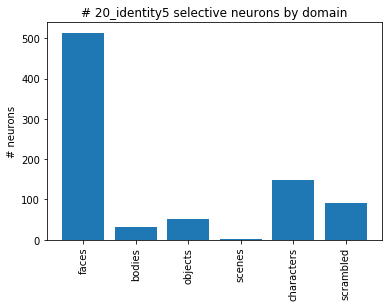

In [133]:
## plots
# selective neurons by domain
plt.figure()
plt.bar(np.arange(len(floc_domains)),pref_dicts['5_conv2']['domain_counts'])
plt.xticks(np.arange(len(floc_domains)),floc_domains,rotation=90);
plt.ylabel('# neurons')
plt.title('# %s selective neurons by domain' % layer);

(20, 6)


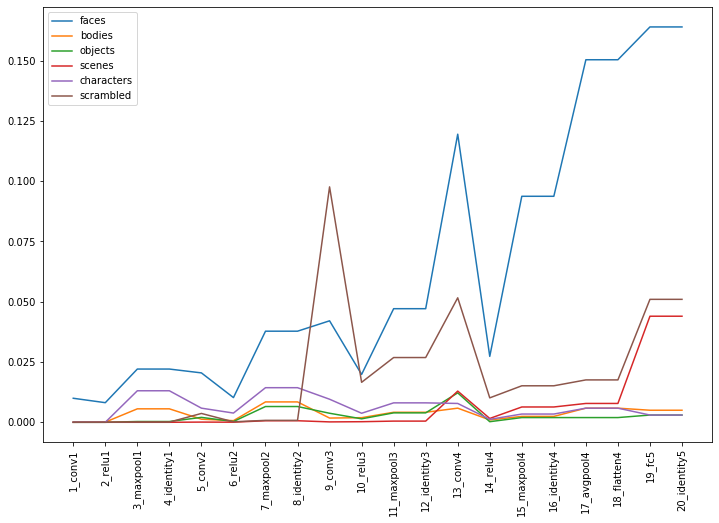

In [132]:
domain_props = []
for i in range(len(layers_to_load)):
    domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
domain_props = np.vstack(domain_props)
print(domain_props.shape)

plt.figure(figsize=(12,8))
plt.plot(domain_props);
plt.legend(floc_domains)
plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);

In [266]:
activation_loaddir = '/home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/cornet-z-object/experimental/mc8-lummatched/dim112/'

layer_list = ['9_conv3']




(16, 6, 28)
['FFA' 'OFA' 'FBA' 'EBA' 'LO' 'PPA' 'TOS' 'MT' 'VentralOTC' 'LateralOTC'
 'OPC' 'EarlyV2' 'VentralOTCRemoved' 'LateralOTCRemoved' 'OPCRemoved'
 'EarlyV2Removed']


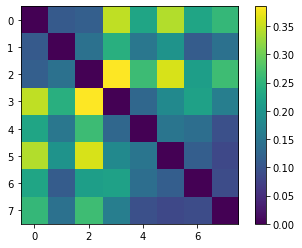

In [272]:
fmri_dir = join(home_dir,'data','d03_processing','Cohen2017')
brain_data = np.load(join(fmri_dir,'fmri_roi_rsa_subcube.npy'))
roi_list = np.load(join(fmri_dir,'roi_list.npy'))
print(brain_data.shape)
print(roi_list)

FFA_rdv = rsa.rsm2rdm(np.nanmean(np.squeeze(brain_data[5]),axis=0))

rsa.plot_matrix(rsa.v2m(FFA_rdv))

In [273]:
maps = []

for layer in layer_list:
    
    print(layer)
    Y = utils.load_batched_activations(activation_loaddir, [layer], 240, reshape_to_2D = False)
    #print(Y.shape)

    cohen_order = np.array([1,3,2,5,7,8,6,4])-1
    Y_categ = rsa.collapse_categs_4D(Y, np.repeat(np.arange(8),30))[cohen_order]
    #print(Y_categ.shape)

    Y = Y_categ
    dim = Y.shape
    #print(dim)
    map_dim = (Y.shape[2], Y.shape[3])
    a = np.zeros((8,8))
    map_depth = len(pdist(a,'correlation'))
    corr_map = np.empty(map_dim)
    corr_map[:] = np.nan

    dn_rdvs = np.zeros((map_dim[0],map_dim[1],map_depth))
    #print(dn_rdvs.shape)

    for i in range(map_dim[0]):
        for j in range(map_dim[1]):
            data = np.squeeze(Y[:,:,i,j])
            data_rdv = rsa.rdv(data)
            corr_map[i,j] = rsa.rdvcorr(FFA_rdv, data_rdv)

    maps.append(corr_map)

9_conv3


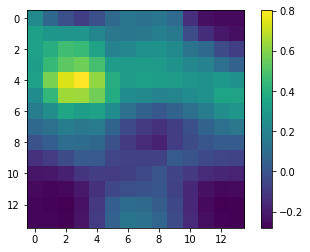

In [274]:
rsa.plot_matrix(corr_map)

IndexError: list index out of range

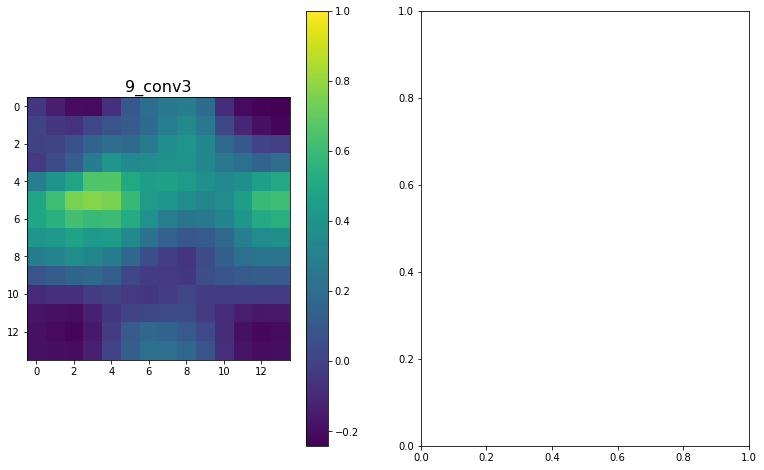

In [270]:
plt.figure(figsize=(20,8))
c = 1
for i in range(3):
    plt.subplot(1,3,c)
    rsa.plot_matrix(maps[c-1],vmin=0,vmax=1,tl=layer_list[c-1],fontsize=16)
    c+=1

In [271]:
maps_ = maps